<a href="https://colab.research.google.com/github/ManjunathShiv/SentinelX/blob/develop/CMAPSS_Predictive_Maintenance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📈 Predictive Maintenance with CMAPSS Dataset

This notebook demonstrates how to load CMAPSS dataset (.h5 format), preprocess it, train an XGBoost model to predict Remaining Useful Life (RUL), and visualize the results.

In [6]:
import os
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor, plot_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import shap

def process_h5_from_path(h5_path):
    if not os.path.isfile(h5_path):
        raise FileNotFoundError(f"❌ File not found at path: {h5_path}")

    with h5py.File(h5_path, 'r') as hdf:
        W = np.concatenate((hdf['W_dev'][:], hdf['W_test'][:]), axis=0)
        X_s = np.concatenate((hdf['X_s_dev'][:], hdf['X_s_test'][:]), axis=0)
        X_v = np.concatenate((hdf['X_v_dev'][:], hdf['X_v_test'][:]), axis=0)
        T = np.concatenate((hdf['T_dev'][:], hdf['T_test'][:]), axis=0)
        A = np.concatenate((hdf['A_dev'][:], hdf['A_test'][:]), axis=0)
        Y = np.concatenate((hdf['Y_dev'][:], hdf['Y_test'][:]), axis=0)

        W_var = [v.decode() for v in hdf['W_var'][:]]
        X_s_var = [v.decode() for v in hdf['X_s_var'][:]]
        X_v_var = [v.decode() for v in hdf['X_v_var'][:]]
        T_var = [v.decode() for v in hdf['T_var'][:]]
        A_var = [v.decode() for v in hdf['A_var'][:]]

    df = pd.concat([
        pd.DataFrame(T, columns=T_var),
        pd.DataFrame(W, columns=W_var),
        pd.DataFrame(X_s, columns=X_s_var),
        pd.DataFrame(X_v, columns=X_v_var),
        pd.DataFrame(A, columns=A_var),
        pd.DataFrame(Y, columns=['RUL'])
    ], axis=1)

    if 'unit' not in df.columns and 'unit' in A_var:
        df['unit'] = pd.DataFrame(A, columns=A_var)['unit']
    if 'cycle' not in df.columns and 'cycle' in A_var:
        df['cycle'] = pd.DataFrame(A, columns=A_var)['cycle']

    if 'unit' not in df.columns or 'cycle' not in df.columns:
        raise ValueError("Missing required columns 'unit' and 'cycle'. Cannot proceed.")

    feature_cols = df.columns.drop('RUL')
    X = df[feature_cols].select_dtypes(include=[np.number])
    y = df['RUL']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = XGBRegressor(n_estimators=300, max_depth=4, learning_rate=0.05,
                         subsample=0.8, colsample_bytree=0.8, random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    df['Predicted_RUL'] = model.predict(X)

    latest = df.groupby('unit')['cycle'].idxmax()
    result_df = df.loc[latest, ['unit', 'cycle', 'Predicted_RUL']].reset_index(drop=True)

    # Plot 1: Completed vs Predicted RUL
    fig1, ax1 = plt.subplots(figsize=(12, 6))
    ax1.bar(result_df['unit'].astype(str), result_df['cycle'], label="Completed", color='skyblue')
    ax1.bar(result_df['unit'].astype(str), result_df['Predicted_RUL'], bottom=result_df['cycle'],
            label="Predicted RUL", color='salmon')
    ax1.set_title("Completed vs Predicted RUL per Engine")
    ax1.set_xlabel("Engine Unit")
    ax1.set_ylabel("Cycles")
    ax1.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()

    # Plot 2: Maintenance Alerts
    maintenance_threshold = 20
    maintenance_engines = result_df[result_df['Predicted_RUL'] <= maintenance_threshold]
    fig2, ax2 = plt.subplots(figsize=(12, 6))
    ax2.bar(maintenance_engines['unit'].astype(str), maintenance_engines['Predicted_RUL'], color='red')
    ax2.axhline(y=maintenance_threshold, color='black', linestyle='--', label='Threshold (20)')
    ax2.set_xlabel("Engine Unit")
    ax2.set_ylabel("Predicted RUL")
    ax2.set_title("Engines Requiring Maintenance (Predicted RUL ≤ 20)")
    ax2.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()

    # Plot 3: Feature Importance
    fig3, ax3 = plt.subplots(figsize=(10, 6))
    plot_importance(model, ax=ax3, importance_type='gain', max_num_features=15)
    ax3.set_title("Top 15 Feature Importances (Gain)")
    plt.tight_layout()

    # Plot 4: SHAP Summary
    explainer = shap.Explainer(model, X_train)
    shap_values = explainer(X_test[:100])
    fig4 = plt.figure(figsize=(10, 6))
    shap.plots.bar(shap_values, max_display=15, show=False)
    plt.title("SHAP Feature Impact (Top 15)")
    plt.tight_layout()

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    metrics_summary = {
      "RMSE": rmse,
      "MAE": mae,
      "R2": r2
    }

    return result_df.head(), fig1, metrics_summary, fig2, fig3, fig4

In [4]:
!pip install xgboost
!pip install shap
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 34.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.7/620.7 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 116.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 35.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 157.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 21.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 7.6 MB/s eta 0:00:00


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os

h5_file_path = "/content/drive/MyDrive/Colab Notebooks/N-CMAPSS_DS02-006.h5"
print(os.path.exists(h5_file_path))  # Should print True if the file is there

True


## 📂 Load CMAPSS Dataset

Top Engine Predictions:


,unit,cycle,Predicted_RUL
0,2.0,75.0,-0.759727
1,5.0,89.0,0.372536
2,10.0,82.0,0.680337
3,11.0,59.0,-0.114640
4,14.0,76.0,0.119971



📊 Metrics: {'RMSE': np.float64(0.6606535984948028), 'MAE': 0.5000104308128357, 'R2': 0.9990883469581604}


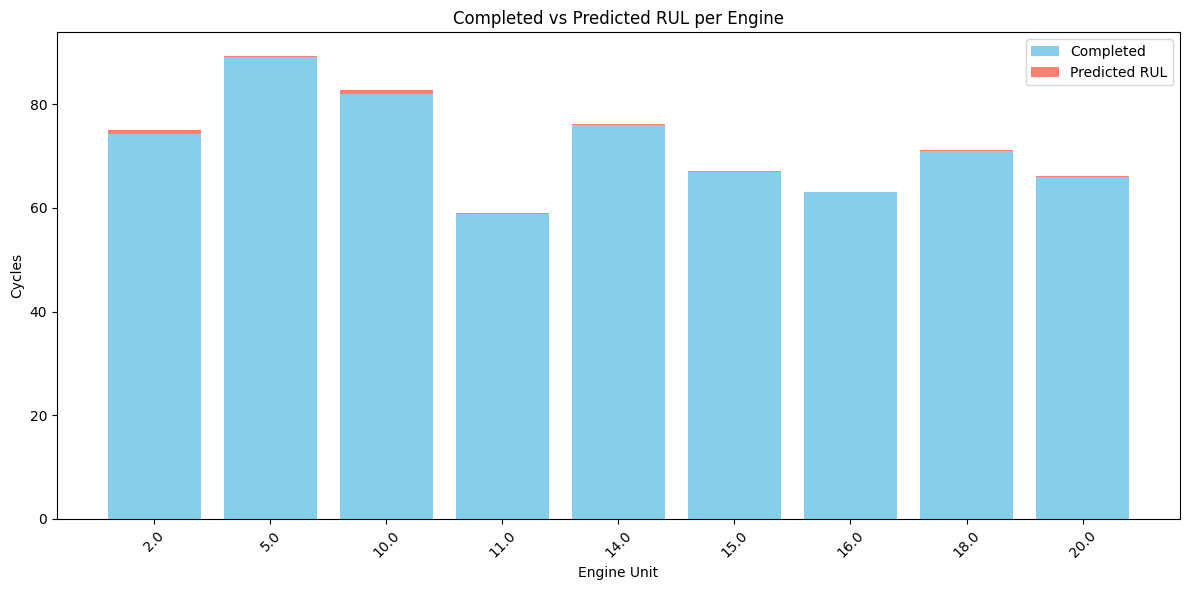

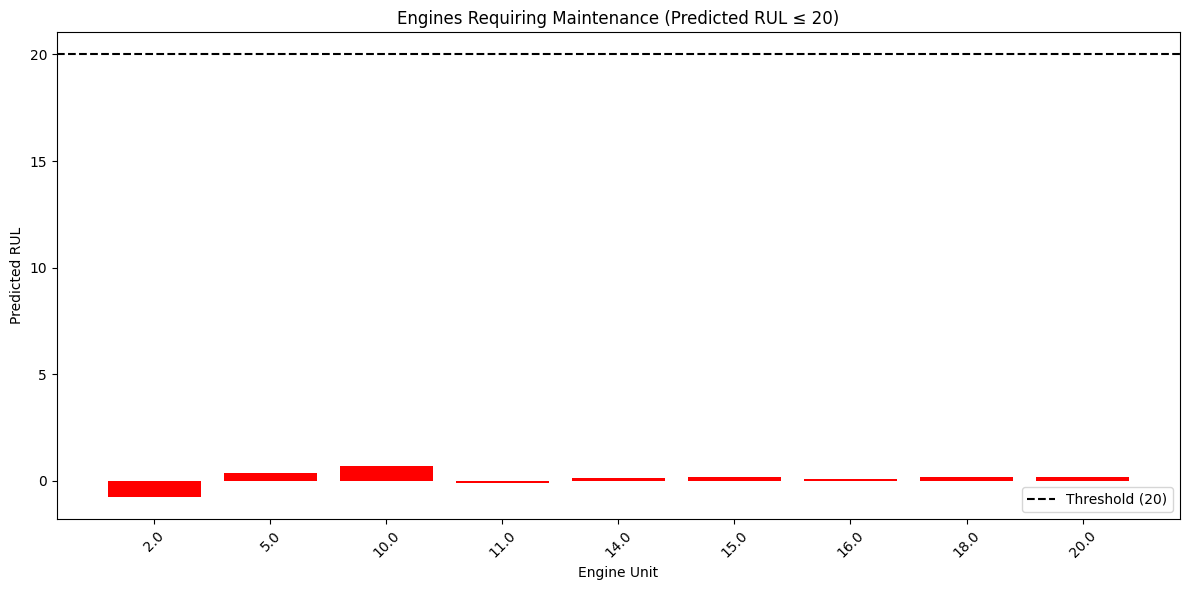

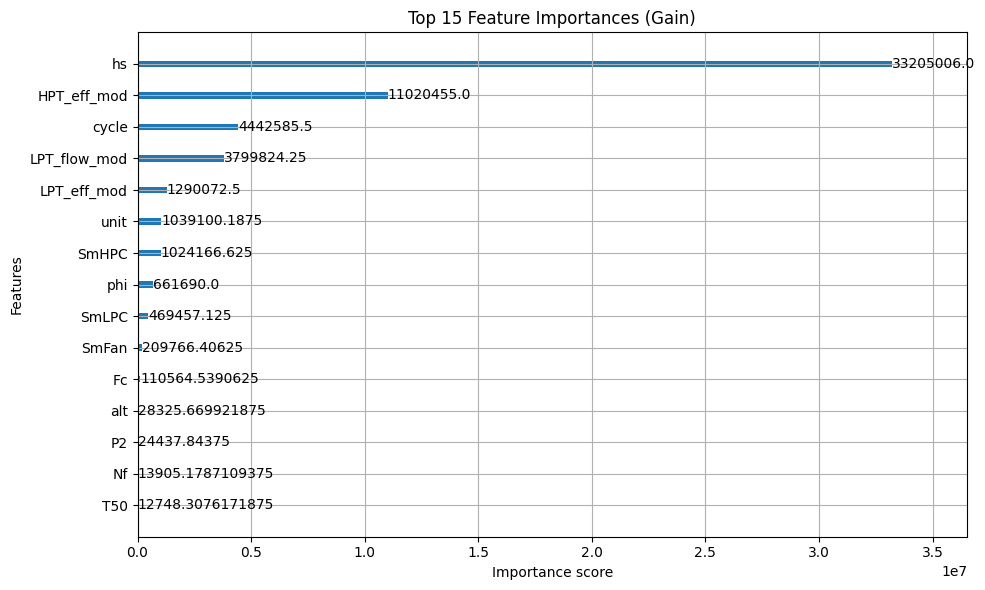

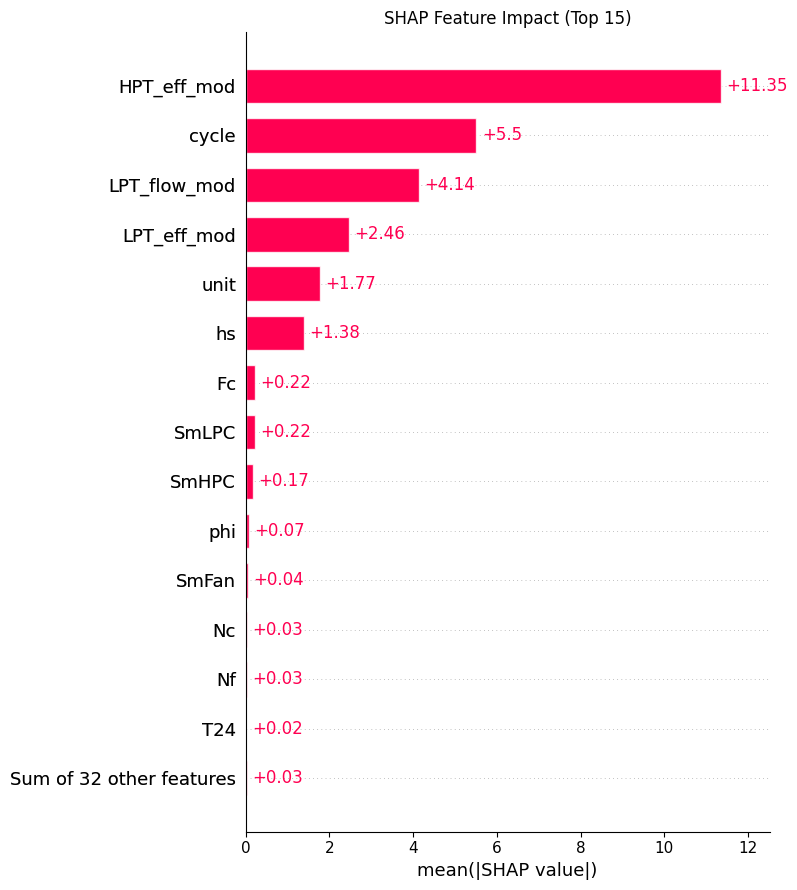

In [9]:
result_df, fig1, metrics, fig2, fig3, fig4 = process_h5_from_path(h5_file_path)

print("Top Engine Predictions:")
display(result_df)
print("\n📊 Metrics:", metrics)
plt.show(fig1)
plt.show(fig2)
plt.show(fig3)
plt.show(fig4)

In [13]:
!pip install gradio
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.7/620.7 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 122.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 139.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 152.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 22.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 7.8 MB/s eta 0:00:00


In [14]:
import os
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gradio as gr
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from google.colab import drive
from tensorflow.keras.callbacks import EarlyStopping

# --------------------------
# MOUNT GOOGLE DRIVE
# --------------------------
drive.mount('/content/drive')
H5_FILE_PATH = "/content/drive/MyDrive/Colab Notebooks/N-CMAPSS_DS02-006.h5"

# --------------------------
# Load dataset (subset for speed)
# --------------------------
def load_ncmapss(h5_path, max_rows=5000):
    if not os.path.isfile(h5_path):
        raise FileNotFoundError(f"❌ File not found: {h5_path}")
    with h5py.File(h5_path, 'r') as hdf:
        W = np.concatenate((hdf['W_dev'][:], hdf['W_test'][:]), axis=0)
        X_s = np.concatenate((hdf['X_s_dev'][:], hdf['X_s_test'][:]), axis=0)
        X_v = np.concatenate((hdf['X_v_dev'][:], hdf['X_v_test'][:]), axis=0)
        T = np.concatenate((hdf['T_dev'][:], hdf['T_test'][:]), axis=0)
        A = np.concatenate((hdf['A_dev'][:], hdf['A_test'][:]), axis=0)
        Y = np.concatenate((hdf['Y_dev'][:], hdf['Y_test'][:]), axis=0)

        W_var = [v.decode() for v in hdf['W_var'][:]]
        X_s_var = [v.decode() for v in hdf['X_s_var'][:]]
        X_v_var = [v.decode() for v in hdf['X_v_var'][:]]
        T_var = [v.decode() for v in hdf['T_var'][:]]
        A_var = [v.decode() for v in hdf['A_var'][:]]

    df = pd.concat([
        pd.DataFrame(T, columns=T_var),
        pd.DataFrame(W, columns=W_var),
        pd.DataFrame(X_s, columns=X_s_var),
        pd.DataFrame(X_v, columns=X_v_var),
        pd.DataFrame(A, columns=A_var),
        pd.DataFrame(Y, columns=['RUL'])
    ], axis=1)

    df = df.head(max_rows)  # ✅ Limit rows for speed

    X = df.drop(columns=['RUL']).select_dtypes(include=[np.number])
    y = df['RUL']

    return X, y

# --------------------------
# Model Training Functions
# --------------------------
def train_xgboost(X_train, X_test, y_train, y_test):
    model = XGBRegressor(
        n_estimators=50, max_depth=3, learning_rate=0.1,
        subsample=0.8, colsample_bytree=0.8, random_state=42
    )
    model.fit(X_train, y_train, verbose=False)
    return model.predict(X_test), model

def train_random_forest(X_train, X_test, y_train, y_test):
    model = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1)
    model.fit(X_train, y_train)
    return model.predict(X_test), model

def create_lstm_data_fast(X, y, time_steps=10):
    n_samples = X.shape[0] - time_steps
    X_seq = np.array([X[i:i+time_steps] for i in range(n_samples)])
    y_seq = y[time_steps:]
    return X_seq, y_seq

def train_lstm(X_train, X_test, y_train, y_test):
    time_steps = 10
    X_train_seq, y_train_seq = create_lstm_data_fast(X_train.values, y_train.values, time_steps)
    X_test_seq, y_test_seq = create_lstm_data_fast(X_test.values, y_test.values, time_steps)

    model = Sequential([
    LSTM(128, return_sequences=True),
    Dropout(0.3),
    LSTM(64),
    Dropout(0.3),
    Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    model.fit(X_train_seq, y_train_seq, epochs=50, validation_split=0.1, callbacks=[early_stop])
    y_pred = model.predict(X_test_seq, verbose=0).flatten()
    return y_pred, model

# --------------------------
# Evaluation
# --------------------------
def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return rmse, mae, r2

# --------------------------
# Main Gradio Function
# --------------------------
def predictive_maintenance():
    X, y = load_ncmapss(H5_FILE_PATH, max_rows=5000)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # XGBoost
    y_pred_xgb, _ = train_xgboost(X_train, X_test, y_train, y_test)
    rmse_xgb, mae_xgb, r2_xgb = evaluate_model(y_test, y_pred_xgb)

    # Random Forest
    y_pred_rf, _ = train_random_forest(X_train, X_test, y_train, y_test)
    rmse_rf, mae_rf, r2_rf = evaluate_model(y_test, y_pred_rf)

    # LSTM
    y_pred_lstm, _ = train_lstm(X_train, X_test, y_train, y_test)
    rmse_lstm, mae_lstm, r2_lstm = evaluate_model(y_test[10:], y_pred_lstm)

    metrics_df = pd.DataFrame({
        "Model": ["XGBoost", "Random Forest", "LSTM"],
        "RMSE": [rmse_xgb, rmse_rf, rmse_lstm],
        "MAE": [mae_xgb, mae_rf, mae_lstm],
        "R²": [r2_xgb, r2_rf, r2_lstm]
    })

    best_model = metrics_df.loc[metrics_df['RMSE'].idxmin(), 'Model']
    conclusion = f"🏆 Best Model: **{best_model}** (lowest RMSE)."

    fig, ax = plt.subplots(figsize=(6, 4))
    ax.bar(metrics_df["Model"], metrics_df["RMSE"], color=['orange', 'blue', 'green'])
    ax.set_ylabel("RMSE")
    ax.set_title("RMSE Comparison")
    plt.tight_layout()

    return metrics_df, fig, conclusion

# --------------------------
# Gradio UI
# --------------------------
iface = gr.Interface(
    fn=predictive_maintenance,
    inputs=None,
    outputs=[
        gr.Dataframe(label="Model Performance Comparison"),
        gr.Plot(label="RMSE Comparison"),
        gr.Markdown(label="Conclusion")
    ],
    title="Predictive Maintenance - Model Comparison (Fast)",
    description="Loads subset of N-CMAPSS dataset from Google Drive and compares LSTM, XGBoost, and Random Forest."
)

iface.launch()


/usr/local/lib/python3.12/dist-packages/jax/_src/cloud_tpu_init.py:82: UserWarning: Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly improved on TPU v5e and newer. If not already set, you may need to enable transparent hugepages in your VM image (sudo sh -c "echo always > /sys/kernel/mm/transparent_hugepage/enabled")
  warnings.warn(


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://b9375ca87be33cdb75.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [2]:
from google.colab import drive

# --------------------------
# MOUNT GOOGLE DRIVE
# --------------------------
drive.mount('/content/drive')
H5_FILE_PATH = "/content/drive/MyDrive/Colab Notebooks/N-CMAPSS_DS02-006.h5"

Mounted at /content/drive


In [5]:
# --------------------------
# Full N-CMAPSS: XGBoost + RF + LSTM Comparison
# Fast Mode + Progress Logs + Charts + Upload/Path/Drive Link support
# --------------------------

import os, re, tempfile, subprocess, sys
import numpy as np
import pandas as pd
import h5py

# sklearn / models
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor

# xgboost (install if needed)
try:
    from xgboost import XGBRegressor
except Exception:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "xgboost"])  # noqa
    from xgboost import XGBRegressor

# tensorflow / keras
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers

# gradio (install if needed)
try:
    import gradio as gr
except Exception:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "gradio>=4.0.0"])  # noqa
    import gradio as gr

# gdown for Google Drive links
try:
    import gdown
except Exception:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "gdown"])  # noqa
    import gdown

SEED = 42
np.random.seed(SEED)

def _is_file(path: str) -> bool:
    try:
        return os.path.isfile(path)
    except Exception:
        return False

# --------------------------
# Fetch local, uploaded path, direct URL or Google Drive file
# --------------------------

def fetch_h5(input_path_or_url: str) -> str:
    """Return a local absolute path to the .h5 file.
    - If it's already a local path -> return abspath
    - If it's a Google Drive link/id -> download with gdown
    - Else treat as direct URL -> download with gdown
    """
    s = str(input_path_or_url).strip().replace("\\", "/")
    if not s:
        raise ValueError("Empty input. Provide local .h5, Drive link, or direct URL.")

    # Local file
    if _is_file(s):
        return os.path.abspath(s)

    # Try to extract Drive file id
    file_id = None
    m = re.search(r"/d/([a-zA-Z0-9_-]{10,})", s)
    if not m:
        m = re.search(r"[?&]id=([a-zA-Z0-9_-]{10,})", s)
    if m:
        file_id = m.group(1)

    out_path = os.path.join(tempfile.gettempdir(), "ncmapss_download.h5")
    if file_id:
        url = f"https://drive.google.com/uc?id={file_id}"
        gdown.download(url, out_path, quiet=False)
        if _is_file(out_path):
            return out_path
        raise FileNotFoundError(f"Failed to download from Drive: {s}")

    # Assume direct URL
    gdown.download(s, out_path, quiet=False)
    if _is_file(out_path):
        return out_path
    raise FileNotFoundError(f"Failed to fetch: {s}")

# --------------------------
# Load H5 -> DataFrame (N-CMAPSS layout)
# --------------------------

def load_ncmapss_df(h5_path: str, downcast: bool = True) -> pd.DataFrame:
    with h5py.File(h5_path, "r") as hdf:
        # Required arrays (dev + test concatenated if present)
        def get_pair(dev_key, test_key):
            a = hdf[dev_key][:] if dev_key in hdf else None
            b = hdf[test_key][:] if test_key in hdf else None
            if a is not None and b is not None:
                return np.concatenate((a, b), axis=0)
            if a is not None:
                return a
            if b is not None:
                return b
            return None

        W  = get_pair('W_dev', 'W_test')
        Xs = get_pair('X_s_dev', 'X_s_test')
        Xv = get_pair('X_v_dev', 'X_v_test')
        T  = get_pair('T_dev', 'T_test')
        A  = get_pair('A_dev', 'A_test')
        Y  = get_pair('Y_dev', 'Y_test')

        if Y is None:
            raise ValueError("Could not find target array 'Y_dev'/'Y_test' in H5.")

        def decode_list(node, fallback_names):
            try:
                if node in hdf:
                    arr = hdf[node][:]
                    return [x.decode() if hasattr(x, 'decode') else str(x) for x in arr]
            except Exception:
                pass
            return fallback_names

        W_var  = decode_list('W_var',  [f"W{i}"  for i in range(W.shape[1])]) if W is not None else []
        Xs_var = decode_list('X_s_var',[f"Xs{i}" for i in range(Xs.shape[1])]) if Xs is not None else []
        Xv_var = decode_list('X_v_var',[f"Xv{i}" for i in range(Xv.shape[1])]) if Xv is not None else []
        T_var  = decode_list('T_var', [f"T{i}"  for i in range(T.shape[1])]) if T is not None else []
        A_var  = decode_list('A_var', [f"A{i}"  for i in range(A.shape[1])]) if A is not None else []

    if downcast:
        for ary_name in ['W','Xs','Xv','T','A','Y']:
            val = locals().get(ary_name)
            if val is not None and val.dtype != np.float32:
                locals()[ary_name] = val.astype(np.float32)
        W, Xs, Xv, T, A, Y = W, Xs, Xv, T, A, Y

    frames = []
    if T is not None:  frames.append(pd.DataFrame(T,  columns=T_var))
    if W is not None:  frames.append(pd.DataFrame(W,  columns=W_var))
    if Xs is not None: frames.append(pd.DataFrame(Xs, columns=Xs_var))
    if Xv is not None: frames.append(pd.DataFrame(Xv, columns=Xv_var))
    if A is not None:  frames.append(pd.DataFrame(A,  columns=A_var))
    frames.append(pd.DataFrame(Y, columns=['RUL']))

    df = pd.concat(frames, axis=1)

    # Fallbacks for grouping/ordering
    if 'unit' not in df.columns:
        # Heuristic: create synthetic unit labels in chunks of 1000 rows
        df['unit'] = np.repeat(np.arange(1, len(df)//1000 + 2), 1000)[:len(df)]
    if 'cycle' not in df.columns:
        df['cycle'] = df.groupby('unit').cumcount() + 1

    return df

# --------------------------
# Split / Scale
# --------------------------

def split_scale(df: pd.DataFrame, feature_cols: list[str]):
    gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=SEED)
    tr_idx, te_idx = next(gss.split(df, groups=df['unit']))
    df_tr = df.iloc[tr_idx].copy()
    df_te = df.iloc[te_idx].copy()
    scaler = StandardScaler()
    scaler.fit(df_tr[feature_cols])
    df_tr[feature_cols] = scaler.transform(df_tr[feature_cols])
    df_te[feature_cols] = scaler.transform(df_te[feature_cols])
    return df_tr, df_te

# --------------------------
# Sequence Windows for LSTM
# --------------------------

def build_windows(df: pd.DataFrame, feature_cols, target='RUL', time_steps=60, stride=1):
    X_list, y_list = [], []
    for _, g in df.groupby('unit'):
        g = g.sort_values('cycle')
        if len(g) < time_steps:
            continue
        mat = g[feature_cols].values
        tgt = g[target].values
        for start in range(0, len(g) - time_steps, stride):
            end = start + time_steps
            X_list.append(mat[start:end])
            y_list.append(tgt[end-1])
    if not X_list:
        return np.zeros((0, time_steps, len(feature_cols)), dtype=np.float32), np.zeros((0,), dtype=np.float32)
    return np.asarray(X_list, dtype=np.float32), np.asarray(y_list, dtype=np.float32)


def make_tf_ds(X, y, batch_size=128):
    return tf.data.Dataset.from_tensor_slices((X, y)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# --------------------------
# LSTM Model
# --------------------------

def build_lstm(timesteps: int, featdim: int):
    inp = layers.Input(shape=(timesteps, featdim))
    x = layers.Bidirectional(layers.LSTM(32, return_sequences=True, dropout=0.2))(inp)
    x = layers.Bidirectional(layers.LSTM(16, return_sequences=False, dropout=0.2))(x)
    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    out = layers.Dense(1, dtype='float32')(x)
    model = models.Model(inp, out)
    model.compile(optimizer=optimizers.Adam(1e-3), loss='mse', metrics=['mae'])
    return model

# --------------------------
# Training + Evaluation
# --------------------------

def compute_metrics(y_true, y_pred):
    rmse = float(np.sqrt(mean_squared_error(y_true, y_pred)))
    mae  = float(mean_absolute_error(y_true, y_pred))
    r2   = float(r2_score(y_true, y_pred))
    return rmse, mae, r2

# --------------------------
# Pipeline (with Fast/Full mode + progress callback)
# --------------------------

def run_all_models(file_path_or_url, fast_mode=True, max_per_unit=300, progress_cb=None):
    def log(msg):
        if progress_cb:
            progress_cb(msg)

    log("📂 Loading dataset…")
    path = fetch_h5(file_path_or_url)
    df = load_ncmapss_df(path)

    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    feature_cols = [c for c in numeric_cols if c not in ('RUL','unit','cycle')]

    if fast_mode:
        log(f"⚡ Fast Mode: sampling up to {max_per_unit} cycles per unit…")
        df = (df.groupby('unit', group_keys=False)
                .apply(lambda g: g.sample(n=min(len(g), int(max_per_unit)), random_state=SEED))
                .reset_index(drop=True))

    log("✂️ Splitting + scaling…")
    df_tr, df_te = split_scale(df, feature_cols)

    # Tabular arrays
    X_tr_tab = df_tr[feature_cols].values
    y_tr_tab = df_tr['RUL'].values
    X_te_tab = df_te[feature_cols].values
    y_te_tab = df_te['RUL'].values

    # XGBoost
    log("🌲 Training XGBoost…")
    xgb = XGBRegressor(n_estimators=50 if fast_mode else 200,
                       max_depth=4 if fast_mode else 6,
                       learning_rate=0.1,
                       random_state=SEED,
                       n_jobs=-1)
    xgb.fit(X_tr_tab, y_tr_tab)
    y_pred_xgb = xgb.predict(X_te_tab)

    # Random Forest
    log("🌳 Training Random Forest…")
    rf = RandomForestRegressor(n_estimators=50 if fast_mode else 200,
                               max_depth=8 if fast_mode else 12,
                               random_state=SEED,
                               n_jobs=-1)
    rf.fit(X_tr_tab, y_tr_tab)
    y_pred_rf = rf.predict(X_te_tab)

    # LSTM sequences
    log("🔁 Building LSTM sequences…")
    time_steps = 30 if fast_mode else 60
    X_tr_seq, y_tr_seq = build_windows(df_tr, feature_cols, time_steps=time_steps)
    X_te_seq, y_te_seq = build_windows(df_te, feature_cols, time_steps=time_steps)

    if X_tr_seq.shape[0] == 0 or X_te_seq.shape[0] == 0:
        log("⚠️ Not enough data to build LSTM sequences — skipping LSTM.")
        lstm_metrics = None
        y_pred_lstm = np.array([])
    else:
        log("🤖 Training LSTM…")
        ds_tr = make_tf_ds(X_tr_seq, y_tr_seq, batch_size=64 if fast_mode else 128)
        ds_te = make_tf_ds(X_te_seq, y_te_seq, batch_size=64 if fast_mode else 128)
        lstm = build_lstm(time_steps, X_tr_seq.shape[2])
        lstm.fit(ds_tr, epochs=3 if fast_mode else 10, verbose=0,
                 callbacks=[callbacks.EarlyStopping(monitor='loss', patience=2, restore_best_weights=True)])
        y_pred_lstm = lstm.predict(ds_te, verbose=0).squeeze()

    log("📊 Computing metrics…")
    rows = []
    rows.append(["XGBoost", *compute_metrics(y_te_tab, y_pred_xgb)])
    rows.append(["Random Forest", *compute_metrics(y_te_tab, y_pred_rf)])
    if y_pred_lstm.size > 0:
        rows.append(["LSTM", *compute_metrics(y_te_seq, y_pred_lstm)])

    df_metrics = pd.DataFrame(rows, columns=["Model","RMSE","MAE","R2"]).sort_values("RMSE")

    preds = {
        "XGBoost": {"y_true": y_te_tab, "y_pred": y_pred_xgb},
        "Random Forest": {"y_true": y_te_tab, "y_pred": y_pred_rf},
    }
    if y_pred_lstm.size > 0:
        preds["LSTM"] = {"y_true": y_te_seq, "y_pred": y_pred_lstm}

    log("✅ Done")
    return df_metrics, preds

# --------------------------
# Plotting helpers (matplotlib)
# --------------------------

import matplotlib.pyplot as plt


def plot_metric_bar(df_metrics: pd.DataFrame, metric: str):
    fig, ax = plt.subplots(figsize=(6, 4))
    vals = df_metrics[["Model", metric]].copy()
    ax.bar(vals["Model"], vals[metric])
    ax.set_title(f"{metric} by Model")
    ax.set_xlabel("Model")
    ax.set_ylabel(metric)
    ax.grid(True, axis='y', linewidth=0.3)
    fig.tight_layout()
    return fig


def plot_pred_vs_actual(y_true: np.ndarray, y_pred: np.ndarray, title: str = "Predicted vs Actual", max_points: int = 500):
    n = min(len(y_true), len(y_pred), max_points)
    fig, ax = plt.subplots(figsize=(7, 4))
    ax.plot(y_true[:n], label="Actual")
    ax.plot(y_pred[:n], label="Predicted")
    ax.legend()
    ax.set_title(title)
    ax.set_xlabel("Sample Index")
    ax.set_ylabel("RUL")
    ax.grid(True, linewidth=0.3)
    fig.tight_layout()
    return fig

# --------------------------
# Gradio UI
# --------------------------

with gr.Blocks() as demo:
    gr.Markdown("## 🔧 N-CMAPSS Predictive Maintenance — XGBoost / RF / LSTM (Fast Mode + Logs + Charts)")

    with gr.Row():
        file_upload = gr.File(label="Upload .h5 File (optional)", type="filepath", file_types=[".h5"])
        path_input = gr.Textbox(label="Or enter local path / Google Drive link / URL", placeholder="/content/drive/MyDrive/Colab Notebooks/N-CMAPSS_DS01-005.h5")

    with gr.Row():
        fast_mode_chk = gr.Checkbox(label="Fast Mode (sample per unit + lighter models)", value=True)
        max_per_unit_slider = gr.Slider(50, 1000, value=300, step=50, label="Max cycles per unit (Fast Mode)")
        run_btn = gr.Button("🚀 Run All Models", variant="primary")

    logs_tb = gr.Textbox(label="Logs", lines=12)

    metrics_df = gr.Dataframe(headers=["Model","RMSE","MAE","R2"], label="Metrics", interactive=False)

    with gr.Row():
        rmse_plot = gr.Plot(label="RMSE by Model")
        mae_plot = gr.Plot(label="MAE by Model")
        r2_plot = gr.Plot(label="R2 by Model")

    with gr.Row():
        model_choice = gr.Dropdown(choices=["XGBoost","Random Forest","LSTM"], value="LSTM", label="Model for Predicted vs Actual plot")
        pred_plot = gr.Plot(label="Predicted vs Actual (selected model)")

    # State to keep predictions from last run
    preds_state = gr.State({})

    def run_gradio(uploaded_path, path_str, fast_mode, max_per_unit, progress=gr.Progress()):
        logs = []
        def cb(msg):
            logs.append(msg)
            try:
                progress(msg)
            except Exception:
                pass

        src = None
        if uploaded_path and str(uploaded_path).strip():
            src = uploaded_path
        elif path_str and str(path_str).strip():
            src = path_str
        else:
            return pd.DataFrame(), plt.figure(), plt.figure(), plt.figure(), { }, "❌ Please provide a file, local path, or URL.", plt.figure()

        try:
            df_metrics, preds = run_all_models(src, fast_mode=bool(fast_mode), max_per_unit=int(max_per_unit), progress_cb=cb)
            logs.append("✅ Done")

            # Build charts
            rmse_fig = plot_metric_bar(df_metrics, "RMSE")
            mae_fig  = plot_metric_bar(df_metrics, "MAE")
            r2_fig   = plot_metric_bar(df_metrics, "R2")

            # Default plot: use LSTM if present else XGBoost
            default_model = "LSTM" if "LSTM" in preds else "XGBoost"
            y_true = preds[default_model]["y_true"]
            y_pred = preds[default_model]["y_pred"]
            pred_fig = plot_pred_vs_actual(y_true, y_pred, title=f"{default_model}: Predicted vs Actual")

            return df_metrics, rmse_fig, mae_fig, r2_fig, preds, "\n".join(logs), pred_fig
        except Exception as e:
            logs.append(f"❌ Error: {e}")
            empty_df = pd.DataFrame(columns=["Model","RMSE","MAE","R2"])
            return empty_df, plt.figure(), plt.figure(), plt.figure(), { }, "\n".join(logs), plt.figure()

    run_btn.click(
        run_gradio,
        inputs=[file_upload, path_input, fast_mode_chk, max_per_unit_slider],
        outputs=[metrics_df, rmse_plot, mae_plot, r2_plot, preds_state, logs_tb, pred_plot]
    )

    def update_pred_plot(preds, selected_model):
        if not isinstance(preds, dict) or selected_model not in preds:
            return plt.figure()
        y_true = preds[selected_model]["y_true"]
        y_pred = preds[selected_model]["y_pred"]
        return plot_pred_vs_actual(y_true, y_pred, title=f"{selected_model}: Predicted vs Actual")

    model_choice.change(update_pred_plot, inputs=[preds_state, model_choice], outputs=pred_plot)

# Launch Gradio
if __name__ == "__main__":
    demo.launch(share=True, debug=True)


/usr/local/lib/python3.12/dist-packages/jax/_src/cloud_tpu_init.py:82: UserWarning: Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly improved on TPU v5e and newer. If not already set, you may need to enable transparent hugepages in your VM image (sudo sh -c "echo always > /sys/kernel/mm/transparent_hugepage/enabled")
  warnings.warn(


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://db62f8fee959f1dd22.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


/tmp/ipython-input-1975713641.py:243: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=min(len(g), int(max_per_unit)), random_state=SEED))


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://db62f8fee959f1dd22.gradio.live


Only LSTM

In [ ]:
# Improved LSTM-only N-CMAPSS Gradio App
# - Sliding-window sequences built per-unit (if unit info exists) to avoid leakage
# - Chronological train/val/test split by unit (no time leakage)
# - Per-feature scaling (MinMax) and optional target scaling (Standard)
# - Robust metric computation (inverse transform, shape checks)
# - Better default model, LR scheduling, and safer R2 handling
# - File upload OR Drive/local path support
# - Returns metrics + prediction plot

import os
import re
import tempfile
import numpy as np
import h5py
import gradio as gr
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GroupShuffleSplit

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# ---------- reproducibility ----------
SEED = 42
np.random.seed(SEED)
try:
    tf.random.set_seed(SEED)
except Exception:
    pass

# ---------- helpers for H5 fetching ----------
try:
    import gdown
    HAS_GDOWN = True
except Exception:
    HAS_GDOWN = False

def fetch_h5_local_or_drive(path_or_url: str) -> str:
    s = str(path_or_url).strip()
    if os.path.isfile(s):
        return os.path.abspath(s)
    if not HAS_GDOWN:
        return s
    # Try Google Drive id extraction
    m = re.search(r"/d/([a-zA-Z0-9_-]{10,})", s) or re.search(r"[?&]id=([a-zA-Z0-9_-]{10,})", s)
    out_path = os.path.join(tempfile.gettempdir(), "ncmapss_lstm_input.h5")
    if m:
        file_id = m.group(1)
        url = f"https://drive.google.com/uc?id={file_id}"
        gdown.download(url, out_path, quiet=False)
        return out_path
    if s.startswith("http://") or s.startswith("https://"):
        gdown.download(s, out_path, quiet=False)
        return out_path
    return s

# ---------- load arrays (features, target, optional unit/cycle) ----------
def _find_first_key(h5, candidates):
    for k in candidates:
        if k in h5:
            return k
    return None

def load_ncmapss_arrays(h5_path: str):
    """
    Returns: X (2D: rows x features), y (1D), optional unit_ids (1D), optional cycle (1D or None)
    Tries a few common keys used in N-CMAPSS-style h5 files.
    """
    with h5py.File(h5_path, "r") as f:
        x_key = _find_first_key(f, ["X_s_dev", "X_s_test", "X_dev", "X_test", "X_s", "X"])
        if x_key is None:
            raise KeyError("Could not find feature array (e.g., 'X_s_dev') in H5")
        X = np.array(f[x_key][:])
        y_key = _find_first_key(f, ["Y_dev", "Y_test", "RUL", "y", "Y"])
        if y_key is None:
            raise KeyError("Could not find target array (e.g., 'Y_dev' or 'RUL') in H5")
        Y = np.array(f[y_key][:])
        # optional unit / cycle arrays
        unit_key = _find_first_key(f, ["unit", "units", "unit_id", "unitIds"])
        cycle_key = _find_first_key(f, ["cycle", "cycles"])
        unit_arr = np.array(f[unit_key][:]) if unit_key is not None else None
        cycle_arr = np.array(f[cycle_key][:]) if cycle_key is not None else None

    # flatten target if needed
    if Y.ndim > 1 and Y.shape[1] == 1:
        Y = Y.ravel()
    # ensure X is 2D
    if X.ndim == 1:
        X = X.reshape(-1, 1)
    return X, Y, unit_arr, cycle_arr

# ---------- sequence creation per-unit (no leakage across units) ----------
def create_sequences_per_unit(X, y, units=None, cycle=None, window=50, stride=5, max_rows_per_unit=None):
    """
    If `units` is provided, build sequences separately for each unit.
    Returns X_seq (n_windows, window, n_features), y_seq (n_windows,)
    and group_ids (n_windows,) indicating from which unit each window came.
    """
    Xs = []
    ys = []
    groups = []
    nrows = X.shape[0]

    if units is None:
        # global series approach (fallback)
        for start in range(0, nrows - window, stride):
            end = start + window
            Xs.append(X[start:end])
            ys.append(y[end - 1])
            groups.append(-1)
        return np.asarray(Xs, dtype=np.float32), np.asarray(ys, dtype=np.float32), np.asarray(groups, dtype=np.int32)

    # group by unit preserving time order
    unique_units = np.unique(units)
    for u in unique_units:
        idx = np.where(units == u)[0]
        if max_rows_per_unit is not None and len(idx) > max_rows_per_unit:
            idx = idx[:max_rows_per_unit]   # keep earliest rows
        # ensure we use rows in increasing cycle/time order
        if cycle is not None:
            order = np.argsort(cycle[idx])
            idx = idx[order]
        for i in range(0, len(idx) - window, stride):
            window_idx = idx[i:i+window]
            Xs.append(X[window_idx])
            ys.append(y[window_idx[-1]])
            groups.append(u)
    if not Xs:
        return np.zeros((0, window, X.shape[1]), dtype=np.float32), np.zeros((0,), dtype=np.float32), np.zeros((0,), dtype=np.int32)
    return np.asarray(Xs, dtype=np.float32), np.asarray(ys, dtype=np.float32), np.asarray(groups, dtype=np.int32)

# ---------- build model ----------
def build_lstm_model(input_shape, units1=128, units2=64, dropout=0.3, lr=5e-4):
    model = Sequential()
    model.add(LSTM(units1, return_sequences=(units2 is not None), input_shape=input_shape))
    if units2 is not None:
        model.add(Dropout(dropout))
        model.add(LSTM(units2))
    model.add(Dropout(dropout))
    model.add(Dense(32, activation="relu"))
    model.add(Dense(1))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss="mse")
    return model

# ---------- main pipeline ----------
def run_lstm_pipeline(
    src_path: str,
    fast_mode: bool = True,
    max_rows_per_unit: int = 5000,
    window: int = 50,
    stride: int = 5,
    epochs: int = 100,
    batch_size: int = 64,
    two_layers: bool = True,
    scale_target: bool = True,
    lr: float = 5e-4,
    use_reduce_lr: bool = True,
    test_unit_fraction: float = 0.2,
    val_unit_fraction: float = 0.1,
    progress: gr.Progress | None = None
):
    def log(msg):
        if progress:
            progress(msg)

    log("Loading H5 file...")
    h5_path = fetch_h5_local_or_drive(src_path)
    X, y, units, cycles = load_ncmapss_arrays(h5_path)

    log(f"Data loaded: rows={len(y)}, features={X.shape[1]}")

    # If fast mode, reduce number of rows per unit (keeps earliest rows)
    if fast_mode:
        log(f"Fast mode: limiting to first {max_rows_per_unit} rows per unit (if available)")
    else:
        log("Full mode: using full data (may be slow)")

    # Scale features per column (MinMax)
    log("Scaling features per column (MinMax)")
    x_scaler = MinMaxScaler()
    X_scaled = x_scaler.fit_transform(X)

    # Optionally scale target (y) for stable training, we'll inverse later
    y_scaler = None
    y_used = y.astype(np.float32)
    if scale_target:
        log("Scaling target (StandardScaler)")
        y_scaler = StandardScaler()
        y_used = y_scaler.fit_transform(y_used.reshape(-1,1)).reshape(-1)

    # Create sliding windows per unit if unit info exists, else global windows
    log("Creating sliding windows (per-unit if unit ids present)...")
    if units is None:
        X_seq, y_seq, groups = create_sequences_per_unit(X_scaled, y_used, units=None, cycle=None,
                                                         window=window, stride=stride, max_rows_per_unit=None)
        # we will split chronologically on sequences (not ideal, but OK if no unit info)
        n_sequences = len(X_seq)
        if n_sequences == 0:
            raise ValueError("Not enough data to create any sequence. Reduce window or increase data.")
        n_train = int((1 - test_unit_fraction - val_unit_fraction) * n_sequences)
        n_val = int(val_unit_fraction * n_sequences)
        X_train, y_train = X_seq[:n_train], y_seq[:n_train]
        X_val, y_val = X_seq[n_train:n_train+n_val], y_seq[n_train:n_train+n_val]
        X_test, y_test = X_seq[n_train+n_val:], y_seq[n_train+n_val:]
    else:
        # build per-unit sequences and then split units into train/val/test (no leakage)
        X_seq, y_seq, groups = create_sequences_per_unit(X_scaled, y_used, units=units, cycle=cycles,
                                                         window=window, stride=stride, max_rows_per_unit=(max_rows_per_unit if fast_mode else None))
        if len(X_seq) == 0:
            raise ValueError("No sequences generated. Try smaller window/stride or check unit data.")
        unique_units = np.unique(groups)
        # split unique units into train/val/test
        np.random.seed(SEED)
        perm = np.random.permutation(unique_units)
        n = len(perm)
        n_test = max(1, int(np.ceil(test_unit_fraction * n)))
        n_val = max(1, int(np.ceil(val_unit_fraction * n)))
        n_train = n - n_test - n_val
        train_units = perm[:n_train]
        val_units = perm[n_train:n_train+n_val]
        test_units = perm[n_train+n_val:]
        train_mask = np.isin(groups, train_units)
        val_mask = np.isin(groups, val_units)
        test_mask = np.isin(groups, test_units)
        X_train, y_train = X_seq[train_mask], y_seq[train_mask]
        X_val, y_val = X_seq[val_mask], y_seq[val_mask]
        X_test, y_test = X_seq[test_mask], y_seq[test_mask]

    log(f"Split sizes -> train: {len(X_train)}, val: {len(X_val)}, test: {len(X_test)}")

    if len(X_train) == 0 or len(X_test) == 0:
        raise ValueError("Empty train or test split. Adjust unit split fractions or data.")

    # Build model
    input_shape = (X_train.shape[1], X_train.shape[2])
    log("Building LSTM model...")
    if two_layers:
        model = build_lstm_model(input_shape, units1=128, units2=64, dropout=0.3, lr=lr)
    else:
        model = build_lstm_model(input_shape, units1=64, units2=None, dropout=0.2, lr=lr)

    # Callbacks
    callbacks = [EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True)]
    if use_reduce_lr:
        callbacks.append(ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=7, min_lr=1e-6, verbose=1))

    # Train
    log("Training model...")
    model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size,
              callbacks=callbacks, verbose=0)

    # Predict on test
    log("Predicting on test set...")
    y_pred_scaled = model.predict(X_test, verbose=0).reshape(-1)
    y_test_scaled = y_test.reshape(-1)

    # inverse-scale target if used
    if scale_target and y_scaler is not None:
        y_pred = y_scaler.inverse_transform(y_pred_scaled.reshape(-1,1)).reshape(-1)
        y_true = y_scaler.inverse_transform(y_test_scaled.reshape(-1,1)).reshape(-1)
    else:
        y_pred = y_pred_scaled
        y_true = y_test_scaled

    # ensure 1-d arrays
    y_true = np.asarray(y_true).reshape(-1).astype(float)
    y_pred = np.asarray(y_pred).reshape(-1).astype(float)

    # compute metrics safely
    rmse = float(np.sqrt(mean_squared_error(y_true, y_pred)))
    mae = float(mean_absolute_error(y_true, y_pred))
    # compute R2, guard against degenerate variance
    try:
        if np.allclose(y_true, y_true[0]) or np.var(y_true) == 0:
            r2 = float('nan')
        else:
            r2 = float(r2_score(y_true, y_pred))
    except Exception:
        r2 = float('nan')

    metrics = {"RMSE": rmse, "MAE": mae, "R2": r2}

    # small diagnostic prints (useful for debugging)
    print("Shapes -> X_train, X_val, X_test:", X_train.shape, X_val.shape, X_test.shape)
    print("y_true (first 10):", y_true[:10])
    print("y_pred (first 10):", y_pred[:10])
    print("Metrics:", metrics)

    # Plot
    N = min(400, len(y_true))
    fig, ax = plt.subplots(figsize=(8,4))
    ax.plot(y_true[:N], label="Actual")
    ax.plot(y_pred[:N], label="Predicted")
    ax.set_title("LSTM — Predicted vs Actual (Test set)")
    ax.set_xlabel("Sample")
    ax.set_ylabel("RUL")
    ax.legend()
    ax.grid(alpha=0.3)
    fig.tight_layout()

    return metrics, fig

# ---------- Gradio UI ----------
with gr.Blocks() as demo:
    gr.Markdown("## 🔧 Improved LSTM — per-unit sliding window, safe metrics, upload or Drive path")

    with gr.Row():
        file_input = gr.File(label="Upload .h5 File", type="filepath", file_types=[".h5"])
        path_input = gr.Textbox(label="Or paste local/Drive path or URL")

    with gr.Row():
        fast_mode = gr.Checkbox(value=True, label="Fast Mode (limit rows per unit for speed)")
        max_rows_per_unit = gr.Slider(1000, 50000, value=5000, step=1000, label="Max rows per unit (fast mode)")
        window = gr.Slider(10, 200, value=50, step=5, label="Window size (timesteps)")
        stride = gr.Slider(1, 20, value=5, step=1, label="Stride")

    with gr.Row():
        epochs = gr.Slider(5, 300, value=100, step=5, label="Epochs")
        batch_size = gr.Slider(16, 256, value=64, step=16, label="Batch size")
        two_layers = gr.Checkbox(value=True, label="Two LSTM layers")

    with gr.Row():
        scale_target = gr.Checkbox(value=True, label="Scale target (recommended)")
        lr = gr.Slider(1e-5, 5e-3, value=5e-4, step=1e-5, label="Learning rate")
        use_reduce_lr = gr.Checkbox(value=True, label="Use ReduceLROnPlateau")

    run_btn = gr.Button("Run LSTM", variant="primary")

    out_metrics = gr.JSON(label="📊 Metrics")
    out_plot = gr.Plot(label="Predicted vs Actual")
    out_logs = gr.Markdown()

    def driver(uploaded_fp, path_str, fast, max_rpu, win, st, ep, bs, two, scale_y, lr_val, use_rlr, progress=gr.Progress()):
        src = None
        if uploaded_fp and str(uploaded_fp).strip():
            src = uploaded_fp
        elif path_str and str(path_str).strip():
            src = path_str
        else:
            return {"error":"Provide file or path"}, plt.figure(), "❌ No input"
        try:
            metrics, fig = run_lstm_pipeline(
                src_path=src,
                fast_mode=bool(fast),
                max_rows_per_unit=int(max_rpu),
                window=int(win),
                stride=int(st),
                epochs=int(ep),
                batch_size=int(bs),
                two_layers=bool(two),
                scale_target=bool(scale_y),
                lr=float(lr_val),
                use_reduce_lr=bool(use_rlr),
                progress=progress
            )
            # ensure numeric R2 (not NaN) for JSON by converting nan -> None
            if isinstance(metrics.get("R2"), float) and np.isnan(metrics["R2"]):
                metrics["R2"] = None
            return metrics, fig, "✅ Done"
        except Exception as e:
            return {"RMSE": None, "MAE": None, "R2": None, "error": str(e)}, plt.figure(), f"❌ Error: {e}"

    run_btn.click(driver,
                  inputs=[file_input, path_input, fast_mode, max_rows_per_unit, window, stride, epochs, batch_size, two_layers, scale_target, lr, use_reduce_lr],
                  outputs=[out_metrics, out_plot, out_logs])

if __name__ == "__main__":
    demo.launch(debug=True)


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://4f269f2f3e88632298.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


LSTM (Long Short-Term Memory) is a special type of Recurrent Neural Network (RNN) in Deep Learning.

It is designed to remember long-term dependencies in sequential data (time-series, text, speech).
It uses special “gates” (input, forget, output gates) to control what information is kept, forgotten, or output at each time step.
Typical use cases:

Predictive maintenance (Remaining Useful Life, RUL prediction)

Natural language processing (translation, sentiment analysis)

Stock market prediction

Speech recognition

Faster LSTM

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [17]:
# Install dependencies in Colab
!pip install gradio tensorflow h5py matplotlib scikit-learn --quiet

import gradio as gr
import h5py
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import Callback, EarlyStopping

SEED = 42
np.random.seed(SEED)

# ----------------------------
# 🔹 Sequence preprocessing with stride + max_per_unit
# ----------------------------
def create_sequences(X, y, window_size=30, stride=5, max_per_unit=200, units=None):
    Xs, ys = [], []
    if units is None:
        units = np.zeros(len(X), dtype=int)

    for unit_id in np.unique(units):
        idx = np.where(units == unit_id)[0]
        if len(idx) > max_per_unit:
            idx = np.random.choice(idx, max_per_unit, replace=False)
        Xi, yi = X[idx], y[idx]
        for start in range(0, len(Xi) - window_size, stride):
            Xs.append(Xi[start:start+window_size])
            ys.append(yi[start+window_size])
    if not Xs:
        return np.zeros((0, window_size, X.shape[1]), dtype=np.float32), np.zeros((0,), dtype=np.float32)
    return np.array(Xs, dtype=np.float32), np.array(ys, dtype=np.float32)

def load_and_preprocess(h5_file_path, seq_len=30, stride=5, max_per_unit=200):
    with h5py.File(h5_file_path, "r") as f:
        if "X_s_dev" in f and "Y_dev" in f:
            X = np.array(f["X_s_dev"])
            y = np.array(f["Y_dev"]).flatten()
        else:
            keys = list(f.keys())
            X = np.array(f[keys[0]])
            y = np.array(f[keys[1]]).flatten()

    # Synthetic unit IDs (approx. chunks of 1000 rows)
    units = np.repeat(np.arange(1, X.shape[0]//1000 + 2), 1000)[:X.shape[0]]

    # Normalize
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)

    # Build sequences
    X_seq, y_seq = create_sequences(X_scaled, y, window_size=seq_len, stride=stride,
                                    max_per_unit=max_per_unit, units=units)
    return X_seq, y_seq

# ----------------------------
# 🔹 LSTM Model
# ----------------------------
def build_lstm(input_shape):
    model = Sequential([
        Bidirectional(LSTM(64, return_sequences=True), input_shape=input_shape),
        Dropout(0.2),
        Bidirectional(LSTM(32)),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer="adam", loss="mse", metrics=["mae"])
    return model

# ----------------------------
# 🔹 Custom Callback for Gradio logging
# ----------------------------
class GradioProgressCallback(Callback):
    def __init__(self, log_list):
        super().__init__()
        self.log_list = log_list

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        msg = f"Epoch {epoch+1}: loss={logs.get('loss'):.4f}, val_loss={logs.get('val_loss'):.4f}, mae={logs.get('mae'):.4f}"
        self.log_list.append(msg)

# ----------------------------
# 🔹 Training + Evaluation
# ----------------------------
def run_lstm(h5_path, h5_file, seq_len=30, stride=5, max_per_unit=200):
    file_path = h5_file if h5_file else h5_path
    if not file_path or file_path.strip() == "":
        return "❌ Provide Google Drive path or upload file", None, None, ""

    try:
        # Load sequences
        X_seq, y_seq = load_and_preprocess(file_path, seq_len=seq_len, stride=stride, max_per_unit=max_per_unit)
        if X_seq.shape[0] == 0:
            return "❌ Not enough data after preprocessing", None, None, ""

        split = int(0.8 * len(X_seq))
        X_train, X_test = X_seq[:split], X_seq[split:]
        y_train, y_test = y_seq[:split], y_seq[split:]

        # Build model
        model = build_lstm((X_train.shape[1], X_train.shape[2]))
        logs = []

        early_stop = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

        # Train with callback
        model.fit(
            X_train, y_train,
            validation_split=0.2,
            epochs=10,
            batch_size=32,
            verbose=0,
            callbacks=[early_stop, GradioProgressCallback(logs)]
        )

        # Predict
        preds = model.predict(X_test).flatten()

        # Metrics
        rmse = np.sqrt(mean_squared_error(y_test, preds))
        mae = mean_absolute_error(y_test, preds)
        r2 = r2_score(y_test, preds)
        metrics = {"RMSE": float(rmse), "MAE": float(mae), "R2": float(r2)}

        # Plot
        fig, ax = plt.subplots(figsize=(10, 5))
        ax.plot(y_test[:500], label="True RUL")
        ax.plot(preds[:500], label="Predicted RUL")
        ax.set_title("LSTM: Predicted vs Actual RUL (first 500 samples)")
        ax.set_xlabel("Samples")
        ax.set_ylabel("RUL")
        ax.legend()
        plt.tight_layout()

        return f"✅ Done. Metrics: {metrics}", preds[:500].tolist(), fig, "\n".join(logs)

    except Exception as e:
        return f"❌ Error: {str(e)}", None, None, ""

# ----------------------------
# 🔹 Gradio UI
# ----------------------------
with gr.Blocks() as demo:
    gr.Markdown("## 🔧 N-CMAPSS Predictive Maintenance — LSTM Only with Live Epoch Logs")

    with gr.Row():
        h5_path = gr.Textbox(label="Google Drive File Path", placeholder="/content/drive/MyDrive/N-CMAPSS_DS01-005.h5")
        h5_file = gr.File(label="Or Upload H5 File", type="filepath", file_types=[".h5"])

    run_button = gr.Button("🚀 RUN LSTM")

    output_text = gr.Textbox(label="Status / Metrics")
    output_preds = gr.JSON(label="Sample Predictions")
    output_plot = gr.Plot(label="Predicted vs Actual RUL")
    output_logs = gr.Textbox(label="Training Progress (Epoch-wise)", lines=10)

    run_button.click(
        fn=run_lstm,
        inputs=[h5_path, h5_file],
        outputs=[output_text, output_preds, output_plot, output_logs]
    )

demo.launch(share=True, debug=True)


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://1c994f5dbf04cb3b19.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1119/1119 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7861 <> https://1c994f5dbf04cb3b19.gradio.live


Error in callback <function _draw_all_if_interactive at 0x7cd70b0691c0> (for post_execute):


KeyboardInterrupt: 

In [ ]:
# ----------------------------
# Install dependencies
# ----------------------------
!pip install gradio tensorflow h5py matplotlib scikit-learn --quiet

import gradio as gr
import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import smtplib
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText

# ----------------------------
# Sequence preprocessing
# ----------------------------
def create_sequences(X, y, window_size=50):
    Xs, ys = [], []
    for i in range(len(X) - window_size):
        Xs.append(X[i:i+window_size])
        ys.append(y[i+window_size])
    return np.array(Xs), np.array(ys)

def load_and_preprocess(h5_file_path, seq_len=50):
    with h5py.File(h5_file_path, "r") as f:
        if "X_s_dev" in f and "Y_dev" in f:
            X = np.array(f["X_s_dev"])
            y = np.array(f["Y_dev"]).flatten()
        else:
            keys = list(f.keys())
            X = np.array(f[keys[0]])
            y = np.array(f[keys[1]]).flatten()

    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)

    X_seq, y_seq = create_sequences(X_scaled, y, window_size=seq_len)
    return X_seq, y_seq

# ----------------------------
# Build LSTM
# ----------------------------
def build_lstm(input_shape):
    model = Sequential([
        LSTM(128, return_sequences=True, input_shape=input_shape),
        Dropout(0.3),
        LSTM(64),
        Dropout(0.3),
        Dense(1)
    ])
    model.compile(optimizer="adam", loss="mse", metrics=["mae"])
    return model

# ----------------------------
# Metrics + Plot
# ----------------------------
def compute_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return {"RMSE": float(rmse), "MAE": float(mae), "R2": float(r2)}

def plot_predictions(y_true, y_pred, max_samples=500):
    fig, ax = plt.subplots(figsize=(10,5))
    n = min(len(y_true), len(y_pred), max_samples)
    ax.plot(y_true[:n], label="True RUL")
    ax.plot(y_pred[:n], label="Predicted RUL")
    ax.set_title("LSTM: Predicted vs Actual RUL")
    ax.set_xlabel("Samples")
    ax.set_ylabel("RUL")
    ax.legend()
    plt.tight_layout()
    return fig

# ----------------------------
# SOS Email
# ----------------------------
def send_sos_email(pred_df, threshold=5):
    alert_units = pred_df[pred_df['predicted_RUL'] <= threshold]
    if alert_units.empty:
        return "✅ No units near EOL. No SOS sent."

    # Email config
    sender_email = "manjunath.sk.85@gmail.com"
    sender_password = "maintenance_password"
    receiver_email = "maintenance_authority@gmail.com"

    subject = "🚨 SOS: Aircraft/Engine Approaching End-of-Life"
    body = "The following units are at or near End-of-Life (RUL ≤ {}):\n\n".format(threshold)
    body += alert_units.to_string(index=False)

    msg = MIMEMultipart()
    msg['From'] = sender_email
    msg['To'] = receiver_email
    msg['Subject'] = subject
    msg.attach(MIMEText(body, 'plain'))

    try:
        server = smtplib.SMTP('smtp.gmail.com', 587)
        server.starttls()
        server.login(sender_email, sender_password)
        server.send_message(msg)
        server.quit()
        return f"✅ SOS email sent for {len(alert_units)} units."
    except Exception as e:
        return f"❌ Failed to send email: {str(e)}"

# ----------------------------
# Highlight RUL ≤ threshold in red
# ----------------------------
def highlight_eol(df, threshold=5):
    def highlight(val):
        color = 'red' if val <= threshold else ''
        return f'background-color: {color}'
    return df.style.applymap(highlight, subset=['predicted_RUL'])

# ----------------------------
# Run LSTM + SOS
# ----------------------------
def run_lstm(h5_path, h5_file, seq_len=50, sos_threshold=5):
    file_path = h5_file if h5_file else h5_path
    if not file_path or file_path.strip() == "":
        return "❌ Please provide a Google Drive path or upload a file.", None, None, None, None

    try:
        X_seq, y_seq = load_and_preprocess(file_path, seq_len=seq_len)
        split = int(0.8 * len(X_seq))
        X_train, X_test = X_seq[:split], X_seq[split:]
        y_train, y_test = y_seq[:split], y_seq[split:]

        model = build_lstm((X_train.shape[1], X_train.shape[2]))
        early_stop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

        model.fit(X_train, y_train,
                  validation_split=0.2,
                  epochs=2,
                  batch_size=64,
                  verbose=1,
                  callbacks=[early_stop])

        preds = model.predict(X_test).flatten()
        metrics = compute_metrics(y_test, preds)
        fig = plot_predictions(y_test, preds)

        unit_ids = np.arange(len(y_seq))
        pred_df = pd.DataFrame({"unit": unit_ids[-len(preds):], "predicted_RUL": preds})
        pred_df = pred_df.sort_values("predicted_RUL", ascending=True).reset_index(drop=True)  # sort ascending
        sos_status = send_sos_email(pred_df, threshold=sos_threshold)

        styled_df = highlight_eol(pred_df, threshold=sos_threshold)

        return f"✅ Training Done. Metrics: {metrics}", preds[:500].tolist(), fig, sos_status, styled_df

    except Exception as e:
        return f"❌ Error: {str(e)}", None, None, None, None

# ----------------------------
# Gradio UI
# ----------------------------
with gr.Blocks() as demo:
    gr.Markdown("## 🔧 N-CMAPSS Predictive Maintenance — LSTM + Sorted RUL + Highlight EOL + SOS Email")

    with gr.Row():
        h5_path = gr.Textbox(label="Google Drive File Path", placeholder="/content/drive/MyDrive/N-CMAPSS_DS01-005.h5")
        h5_file = gr.File(label="Or Upload H5 File", type="filepath", file_types=[".h5"])

    sos_threshold = gr.Slider(0, 20, value=5, step=1, label="RUL Threshold for SOS Email")
    run_button = gr.Button("🚀 RUN LSTM & Send SOS")

    output_text = gr.Textbox(label="Status / Metrics")
    output_preds = gr.JSON(label="Sample Predictions (first 500)")
    output_plot = gr.Plot(label="Predicted vs Actual RUL")
    output_sos = gr.Textbox(label="SOS Email Status")
    output_table = gr.Dataframe(label="Full Predicted RUL Table (sorted, RUL ≤ threshold highlighted in red)")

    run_button.click(
        fn=run_lstm,
        inputs=[h5_path, h5_file, gr.Number(value=50, visible=False), sos_threshold],
        outputs=[output_text, output_preds, output_plot, output_sos, output_table]
    )

demo.launch(share=True, debug=True)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.6/59.6 MB 63.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.6/324.6 kB 35.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.7/620.7 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 133.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.6/95.6 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 146.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.2/121.2 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 199.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.0/73.0 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 58.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 

/usr/local/lib/python3.12/dist-packages/jax/_src/cloud_tpu_init.py:82: UserWarning: Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly improved on TPU v5e and newer. If not already set, you may need to enable transparent hugepages in your VM image (sudo sh -c "echo always > /sys/kernel/mm/transparent_hugepage/enabled")
  warnings.warn(


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://482f7b463cb9070be4.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/2
52634/52634 ━━━━━━━━━━━━━━━━━━━━ 2370s 45ms/step - loss: 541.2469 - mae: 19.6097 - val_loss: 443.7658 - val_mae: 18.0180
Epoch 2/2
52634/52634 ━━━━━━━━━━━━━━━━━━━━ 2374s 45ms/step - loss: 514.8789 - mae: 19.2351 - val_loss: 59.1011 - val_mae: 5.2958
32897/32897 ━━━━━━━━━━━━━━━━━━━━ 282s 9ms/step


/tmp/ipython-input-3377269433.py:121: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  return df.style.applymap(highlight, subset=['predicted_RUL'])
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/gradio/queueing.py", line 626, in process_events
    response = await route_utils.call_process_api(
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/gradio/route_utils.py", line 349, in call_process_api
    output = await app.get_blocks().process_api(
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/gradio/blocks.py", line 2284, in process_api
    data = await self.postprocess_data(block_fn, result["prediction"], state)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/gradio/blocks.py", line 2062, in postprocess_data
    prediction_value = block.postprocess(